### [Anomaly Detection for Dummies](https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1)

Dataset: [Superstore Sales](https://community.tableau.com/docs/DOC-1236)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest

#### Load and understand data

In [3]:
df = pd.read_excel('./datasets/superstore.xls')

 - **Distribution of sales in the data**

In [4]:
df['Sales'].describe()

count     9994.000000
mean       229.858001
std        623.245101
min          0.444000
25%         17.280000
50%         54.490000
75%        209.940000
max      22638.480000
Name: Sales, dtype: float64

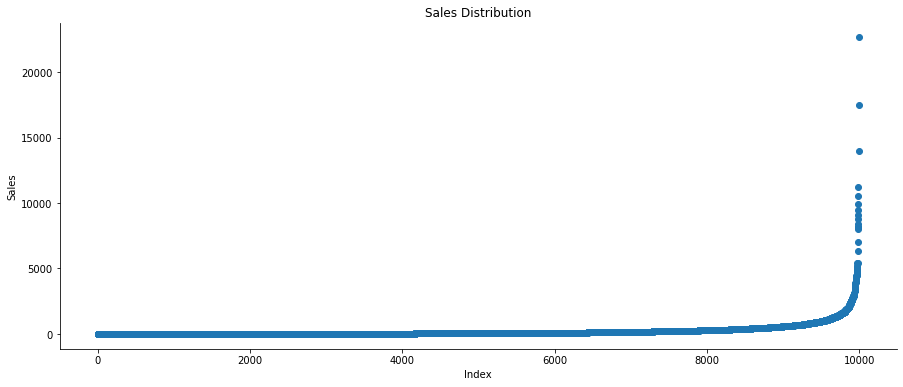

In [5]:
plt.figure(figsize=(15, 6))
plt.scatter(range(df.shape[0]), np.sort(df['Sales'].values))
plt.xlabel('Index')
plt.ylabel('Sales')
plt.title('Sales Distribution')
sns.despine()

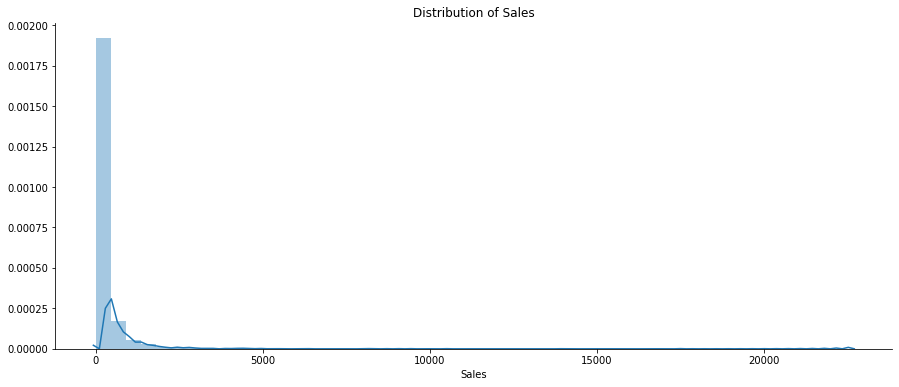

In [6]:
plt.figure(figsize=(15, 6))
sns.distplot(df['Sales'])
plt.title('Distribution of Sales')
sns.despine()

In [7]:
print('Skewness: {}'.format(df['Sales'].skew()))
print('Kurtosis: {}'.format(df['Sales'].kurt()))

Skewness: 12.972752341816228
Kurtosis: 305.31175324682283


 - **Distribution of Profit**

In [8]:
df['Profit'].describe()

count    9994.000000
mean       28.656896
std       234.260108
min     -6599.978000
25%         1.728750
50%         8.666500
75%        29.364000
max      8399.976000
Name: Profit, dtype: float64

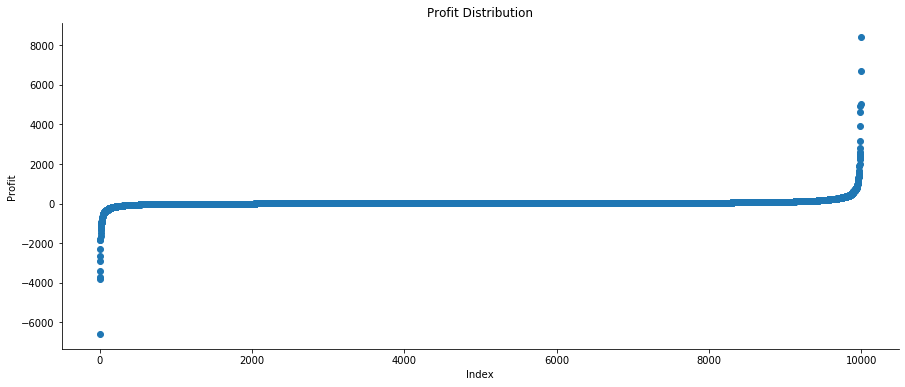

In [9]:
plt.figure(figsize=(15, 6))
plt.scatter(range(df.shape[0]), np.sort(df['Profit'].values))
plt.xlabel('Index')
plt.ylabel('Profit')
plt.title('Profit Distribution')
sns.despine()

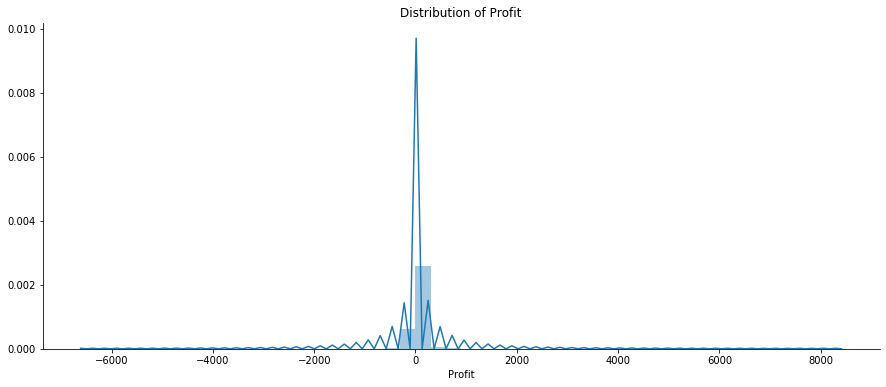

In [10]:
plt.figure(figsize=(15, 6))
sns.distplot(df['Profit'])
plt.title('Distribution of Profit')
sns.despine()

In [11]:
print('Skewness: {}'.format(df['Profit'].skew()))
print('Kurtosis: {}'.format(df['Profit'].kurt()))

Skewness: 7.561431562468336
Kurtosis: 397.188514552414


#### Univariate anamoly detection on Sales

Train [IsolationForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) using the Sales data.

In [12]:
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df['Sales'].values.reshape(-1, 1))

IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

Store the Sales in `NumPy` array.

In [13]:
xx = np.linspace(df['Sales'].min(), df['Sales'].max(), len(df)).reshape(-1, 1)

Compute anamoly score.

In [14]:
anomaly_score = isolation_forest.decision_function(xx)

Classify outliers.

In [15]:
outlier = isolation_forest.predict(xx)

C:\Users\harshil\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Visualization to identify regions where outliers fall.

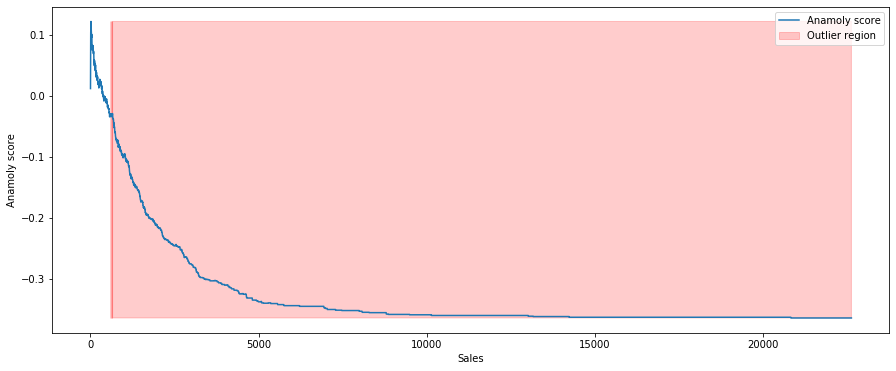

In [16]:
plt.figure(figsize=(15, 6))

plt.plot(xx, anomaly_score, label='Anamoly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), where=outlier==-1, color='r', alpha=.2, label='Outlier region')
plt.legend()

plt.ylabel('Anamoly score')
plt.xlabel('Sales');

According to this visualization, Sales that exceeds 1000 would definitely be considered as an outlier.

#### Univariate anamoly detection on Profit

Train [IsolationForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) using the Profit data.

In [17]:
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df['Profit'].values.reshape(-1, 1))

IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

Store the Profit in `NumPy` array.

In [18]:
xx = np.linspace(df['Profit'].min(), df['Profit'].max(), len(df)).reshape(-1, 1)

Compute anamoly score.

In [19]:
anomaly_score = isolation_forest.decision_function(xx)

Classify outliers.

In [20]:
outlier = isolation_forest.predict(xx)

C:\Users\harshil\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Visualization to identify regions where outliers fall.

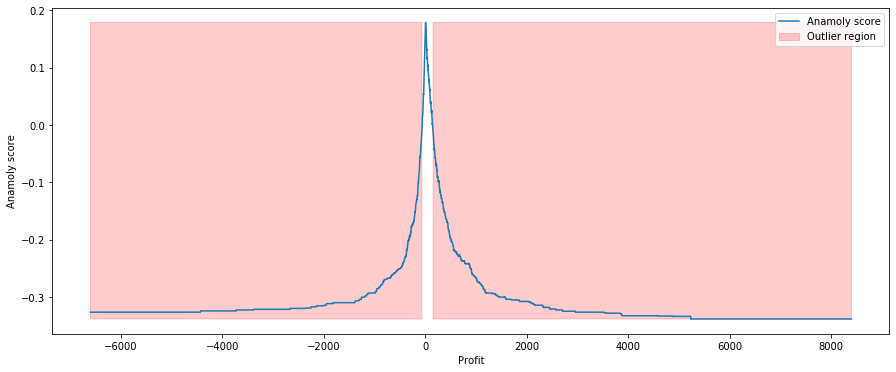

In [21]:
plt.figure(figsize=(15, 6))

plt.plot(xx, anomaly_score, label='Anamoly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), where=outlier==-1, color='r', alpha=.2, label='Outlier region')
plt.legend()

plt.ylabel('Anamoly score')
plt.xlabel('Profit');